# Monge gap

In [1]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import dataclasses
from types import MappingProxyType
from typing import Any, Dict, Iterator, Literal, Mapping, Optional, Tuple, Union

import jax
import jax.numpy as jnp
import optax
import sklearn.datasets
from flax import linen as nn

from matplotlib import pyplot as plt

from ott import datasets
from ott.geometry import costs, pointcloud
from ott.neural import losses, models
from ott.neural.solvers import map_estimator
from ott.solvers.linear import acceleration
from ott.tools import sinkhorn_divergence

## The Monge gap: a regularizer to promote "OT-like" maps

We seek to learn an optimal transport (Monge) map $T^\star$ between two probability measures $\mu, \nu$ in $\mathbb{R}^d$, w.r.t. a cost function $c : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$, namely:

$$
T^\star \in \arg\min_{\substack{T:\mathbb{R}^d \rightarrow \mathbb{R}^d \\ T \sharp \mu = \nu}} \int c(x,T(x)) \mathrm{d}\mu(x)
$$

We show how to use the {func}`~ott.neural.losses.monge_gap`, a regularizer proposed by {cite}`uscidda:23` to do so. Computing an OT map can be split into two goals: move mass efficiently from $\mu$ to $T\sharp\mu$ (this is the objective), while, at the same time, making sure $T\sharp\mu$ "lands" on $\nu$ (the constraint).

The first requirement (efficiency) can be quantified with the **Monge gap** $\mathcal{M}_\mu^c$, a non-negative regularizer defined through $\mu$ and $c$, and which takes as an argument any map $T : \mathbb{R}^d \rightarrow \mathbb{R}^d$. The value $\mathcal{M}_\mu^c(T)$ quantifies how $T$ moves mass efficiently between $\mu$ and $T \sharp \mu$, and only cancels $\mathcal{M}_\mu^c(T) = 0$ i.f.f. $T$ is optimal between $\mu$ and $T \sharp \mu$ for the cost $c$.

The second requirement (landing on $\nu$) is then simply handled using a fitting loss $\Delta$ between $T \sharp \mu$ and $\nu$. This can be measured, e.g., using a {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence`. Introducing a regularization strength $\lambda_\mathrm{MG} > 0$, looking for a Monge map can be reformulated as finding a $T$ that minimizes:

$$
\min_{T:\mathbb{R}^d \rightarrow \mathbb{R}^d} \Delta(T\sharp \mu, \nu) + \lambda_\mathrm{MG} \mathcal{M}_\mu^c(T)
$$

We parameterize maps $T$ as neural networks $\{T_\theta\}_{\theta \in \mathbb{R}^d}$, using the {class}`~ott.neural.solvers.map_estimator.MapEstimator` solver. For the squared-Euclidean cost, this method provides a simple alternative to the {class}`~ott.neural.solvers.neuraldual.W2NeuralDual` solver, but one that does not require parameterizing networks as gradients of convex functions.

## Data Generation

We generate some simple datasets for this notebook.

In [3]:
@dataclasses.dataclass
class SklearnDistribution:
    """A class to define toy probability 2-dimensional distributions.

    Produces rotated ``moons`` and ``s_curve`` sklearn datasets, using
    ``theta_rotation``.
    """

    name: Literal["moon", "s_curve"]
    theta_rotation: float = 0.0
    mean: Optional[jnp.ndarray] = None
    noise: float = 0.01
    scale: float = 1.0
    batch_size: int = 1024
    rng: Optional[jax.Array] = None

    def __iter__(self) -> Iterator[jnp.ndarray]:
        """Random sample generator from Gaussian mixture.

        Returns:
        A generator of samples from the Gaussian mixture.
        """
        return self._create_sample_generators()

    def _create_sample_generators(self) -> Iterator[jnp.ndarray]:
        rng = jax.random.PRNGKey(0) if self.rng is None else self.rng

        # define rotation matrix tp rotate samples
        rotation = jnp.array(
            [
                [jnp.cos(self.theta_rotation), -jnp.sin(self.theta_rotation)],
                [jnp.sin(self.theta_rotation), jnp.cos(self.theta_rotation)],
            ]
        )
        while True:
            rng, _ = jax.random.split(rng)
            seed = jax.random.randint(rng, [], minval=0, maxval=1e5).item()
            if self.name == "moon":
                samples, _ = sklearn.datasets.make_moons(
                    n_samples=(self.batch_size, 0),
                    random_state=seed,
                    noise=self.noise,
                )
            elif self.name == "s_curve":
                x, _ = sklearn.datasets.make_s_curve(
                    n_samples=self.batch_size,
                    random_state=seed,
                    noise=self.noise,
                )
                samples = x[:, [2, 0]]
            else:
                raise NotImplementedError(
                    f"SklearnDistribution `{self.name}` not implemented."
                )

            samples = jnp.asarray(samples, dtype=jnp.float32)
            samples = jnp.squeeze(jnp.matmul(rotation[None, :], samples.T).T)
            mean = jnp.zeros(2) if self.mean is None else self.mean
            samples = mean + self.scale * samples
            yield samples


def create_samplers(
    source_kwargs: Mapping[str, Any] = MappingProxyType({}),
    target_kwargs: Mapping[str, Any] = MappingProxyType({}),
    train_batch_size: int = 256,
    valid_batch_size: int = 256,
    rng: Optional[jax.Array] = None,
) -> Tuple[datasets.Dataset, datasets.Dataset, int]:
    """Samplers from ``SklearnDistribution``."""
    rng = jax.random.PRNGKey(0) if rng is None else rng
    rng1, rng2, rng3, rng4 = jax.random.split(rng, 4)
    train_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng1, batch_size=train_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng2, batch_size=train_batch_size, **target_kwargs
            )
        ),
    )
    valid_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng3, batch_size=valid_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng4, batch_size=valid_batch_size, **target_kwargs
            )
        ),
    )
    dim_data = 2
    return train_dataset, valid_dataset, dim_data

We also define a plot function to display results

In [4]:
def plot_samples(
    batch: Dict[str, Any],
    num_points: Optional[int] = None,
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (8, 6),
    rng: Optional[jax.Array] = None,
):
    """Plot samples from the source and target measures.

    If source samples mapped by the fitted map are provided in ``batch``,
    the function plots these predictions as well.
    """
    rng = jax.random.PRNGKey(0) if rng is None else rng
    fig, ax = plt.subplots(figsize=figsize)
    if num_points is None:
        subsample = jnp.arange(len(batch["source"]))
    else:
        subsample = jax.random.choice(
            rng, a=len(batch["source"]), shape=(num_points,)
        )
    ax.scatter(
        batch["source"][subsample, 0],
        batch["source"][subsample, 1],
        label="source",
        c="b",
        edgecolors="k",
        s=300,
        alpha=0.8,
    )
    ax.scatter(
        batch["target"][subsample, 0],
        batch["target"][subsample, 1],
        label="target",
        c="r",
        edgecolors="k",
        marker="X",
        s=300,
        alpha=0.6,
    )
    bool_plot_pred = "mapped_source" in batch
    if "mapped_source" in batch:
        ax.scatter(
            batch["mapped_source"][subsample, 0],
            batch["mapped_source"][subsample, 1],
            label="push-forward",
            c="orange",
            edgecolors="k",
            marker="X",
            s=300,
            alpha=0.8,
        )
        z = batch["mapped_source"] - batch["source"]
        ax.quiver(
            batch["source"][subsample, 0],
            batch["source"][subsample, 1],
            z[subsample, 0],
            z[subsample, 1],
            angles="xy",
            scale_units="xy",
            scale=1.0,
            width=0.003,
            headwidth=10,
            headlength=10,
            color="dodgerblue",
            edgecolor="k",
            alpha=0.5,
        )
    if title is None:
        title = (
            r"Fitted map $\hat{T}_\theta$"
            if bool_plot_pred
            else r"Source and Target Measures"
        )
    ax.set_title(title, fontsize=20, y=1.01)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.legend(fontsize=16)
    fig.tight_layout()
    plt.show()

We can now use these tools to create the task

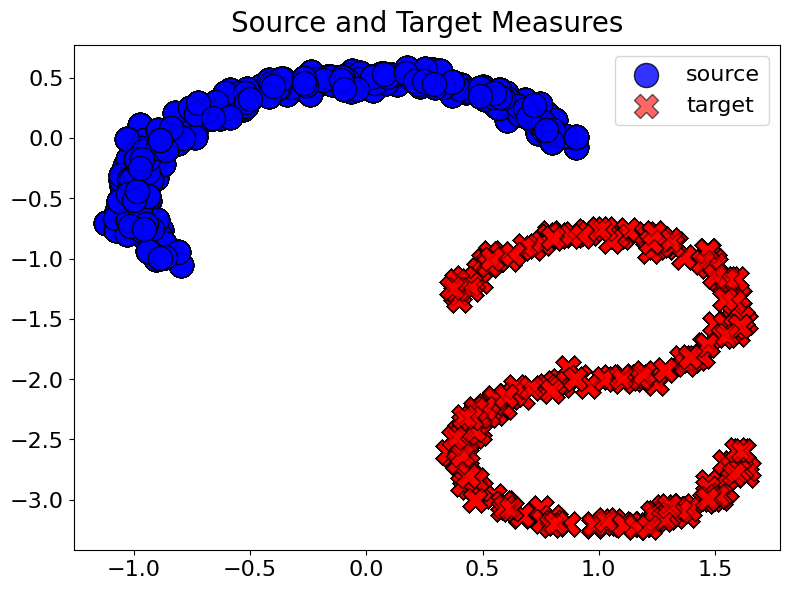

In [5]:
train_dataset, valid_dataset, dim_data = create_samplers(
    source_kwargs={
        "name": "moon",
        "theta_rotation": jnp.pi / 6,
        "mean": jnp.array([0.0, -0.5]),
        "noise": 0.05,
    },
    target_kwargs={
        "name": "s_curve",
        "scale": 0.6,
        "mean": jnp.array([1.0, -2.0]),
        "theta_rotation": jnp.pi / 2,
        "noise": 0.05,
    },
)

batch = {}
batch["source"] = next(train_dataset.source_iter)
batch["target"] = next(train_dataset.target_iter)
plot_samples(batch=batch, num_points=10000)

## Learning Maps: Losses, Hyperparameters and Training Loop

The `fit_map` function below implements the following minimization:

$$
\min_{T:\mathbb{R}^d \rightarrow \mathbb{R}^d} \Delta(T\sharp \mu, \nu) + \lambda_\mathrm{MG} \mathcal{M}_\mu^c(T)
$$
For all fittings, we use $\Delta = S_{\varepsilon, \ell_2^2}$, the {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence` with the {class}`squared-Euclidean cost <ott.geometry.costs.SqEuclidean>`
The function considers a ground cost function `cost_fn` (corresponding to $c$), as well as the `epsilon` regularization parameters to compute approximated Wasserstein distances, both for fitting and regularizer.

In [6]:
def fit_map(
    cost_fn,
    relative_epsilon_fitting=1e-1,
    relative_epsilon_regularizer=1e-2,
    regularizer_strength=1.0,
    num_train_iters=5000,
):
    dim_data = 2
    # define the neural map
    model = models.MLP(
        dim_hidden=[32, 64, 32], is_potential=False, act_fn=nn.gelu
    )

    # define the optimizer to learn the neural map
    lr = 1e-3
    optimizer = optax.adam(learning_rate=lr)

    # Compute an order of magnitude for epsilon fitting
    y = next(train_dataset.target_iter)
    epsilon_fitting_scale = pointcloud.PointCloud(y).mean_cost_matrix
    epsilon_fitting = relative_epsilon_fitting * epsilon_fitting_scale
    print("Selected `epsilon_fitting`:", epsilon_fitting)

    @jax.jit
    def fitting_loss(x, y):
        out = sinkhorn_divergence.sinkhorn_divergence(
            pointcloud.PointCloud, x, y, epsilon=epsilon_fitting, static_b=True
        )
        return out.divergence, out.n_iters

    if cost_fn is None:
        regularizer = None
    else:
        # Compute an order of magnitude for epsilon regularizer
        x = next(train_dataset.source_iter)
        epsilon_regularizer_scale = pointcloud.PointCloud(x, y).mean_cost_matrix
        epsilon_regularizer = (
            relative_epsilon_regularizer * epsilon_regularizer_scale
        )
        print("Selected `epsilon_regularizer`:", epsilon_regularizer)

        def regularizer(x, y):
            gap, out = losses.monge_gap_from_samples(
                x,
                y,
                cost_fn=cost_fn,
                epsilon=epsilon_regularizer,
                return_output=True,
            )
            return gap, out.n_iters

    # define solver
    solver = map_estimator.MapEstimator(
        dim_data=dim_data,
        fitting_loss=fitting_loss,
        regularizer=regularizer,
        model=model,
        optimizer=optimizer,
        regularizer_strength=regularizer_strength,
        num_train_iters=num_train_iters,
        logging=True,
        valid_freq=25,
    )

    return solver.train_map_estimator(
        trainloader_source=train_dataset.source_iter,
        trainloader_target=train_dataset.target_iter,
        validloader_source=valid_dataset.source_iter,
        validloader_target=valid_dataset.target_iter,
    )


def plot_fit_map(title_prefix, neural_state, logs, num_points=30):
    plt.figure(figsize=(9, 3))
    plt.plot(logs["eval"]["total_loss"], label="total loss")
    reg = logs["eval"].get("regularizer")
    if reg[0] > 0.0:
        plt.plot(reg, label="regularizer")
        plt.plot(logs["eval"].get("fitting_loss"), label="fitting loss")

    plt.title("Evaluation error")
    plt.xlabel("Validation iteration")
    plt.legend()
    plt.loglog()

    # plot the fitted map
    batch["mapped_source"] = neural_state.apply_fn(
        {"params": neural_state.params},
        batch["source"][:, :num_points],
    )
    plot_samples(
        batch=batch,
        num_points=num_points,
        title=r"Fitted map $\hat{T}_\theta$, " + title_prefix,
    )
    sink_its = logs["eval"]["log_fitting"]
    print(
        "Avg # of Sinkhorn iterations for fitting loss",
        10
        * jnp.mean(jnp.array([sink_its[i][0] for i in range(len(sink_its))])),
    )
    if reg[0] > 0.0:
        sink_its = logs["eval"]["log_regularizer"]
        print(
            "Avg # of Sinkhorn iterations for regularizer",
            10
            * jnp.mean(jnp.array([sink_its[i] for i in range(len(sink_its))])),
        )

We can now examine how these maps vary, depending on whether the Monge gap was used or not.

## No Monge Gap
When fitting without a Monge gap, one recovers an arbitrary push-forward, which has no reason to be optimal for any cost.

In [7]:
out_nn, logs = fit_map(None)

Selected `epsilon_fitting`: 0.17911479


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:11<00:00, 19.88it/s, fitting_loss: 0.1896, regularizer: NA ,total: 0.1896]


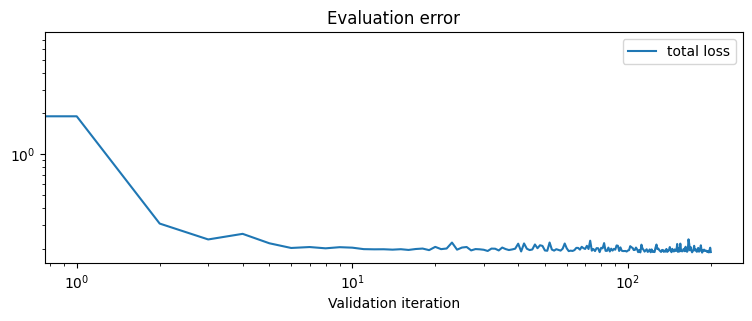

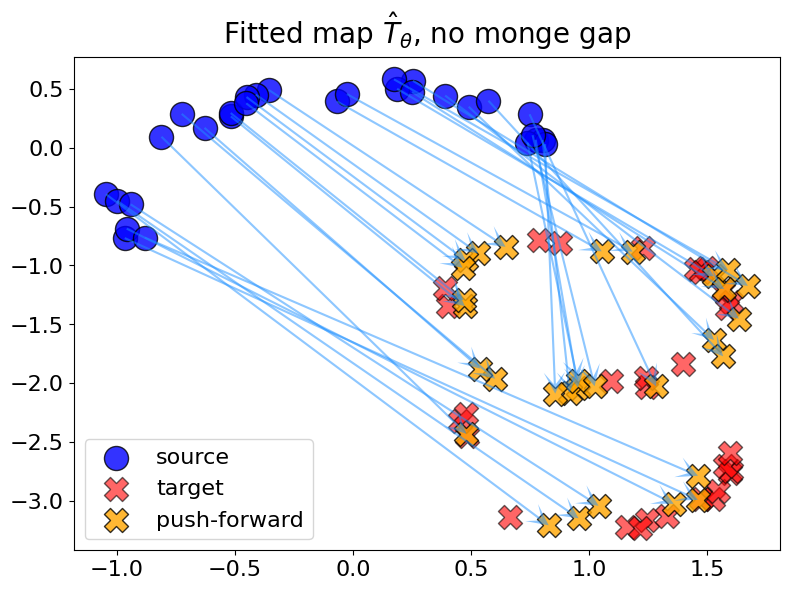

Avg # of Sinkhorn iterations for fitting loss 563.1841


In [8]:
plot_fit_map("no monge gap", out_nn, logs)

For the Monge gap with $c = \ell_2$, we obtain a "needle" alignment (without crossing lines) because $c$ is a distance: this is known as the Monge Mather shortening principle (see e.g. {cite}`villani:09`).

In [9]:
out_nn_l2, logs_l2 = fit_map(costs.Euclidean(), regularizer_strength=2.0)

Selected `epsilon_fitting`: 0.17044167
Selected `epsilon_regularizer`: 0.06964297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:25<00:00, 15.36it/s, fitting_loss: 0.2151, regularizer: 0.7066 ,total: 1.6283]


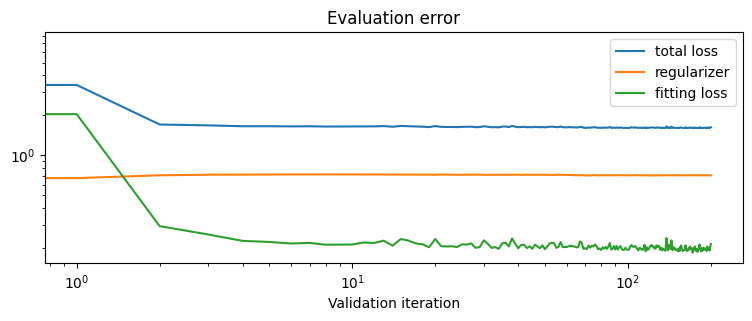

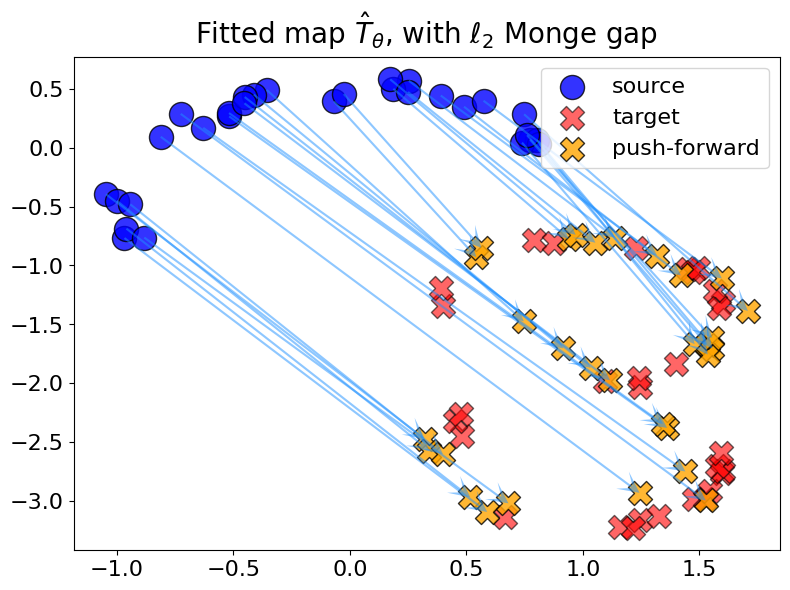

Avg # of Sinkhorn iterations for fitting loss 565.67163
Avg # of Sinkhorn iterations for regularizer 200.99503


In [10]:
plot_fit_map(rf"with $\ell_2$ Monge gap", out_nn_l2, logs_l2)

For $c = \ell_2^2$, we observe crossings when the sum of the squared diagonals of the quadrilateral induced by 4 points $(x_1, x_2, T(x_1), T(x_2))$ is lower than the sum of the squared sides. 

In [ ]:
out_nn_l22, logs_l22 = fit_map(costs.SqEuclidean(), regularizer_strength=0.1)

Selected `epsilon_fitting`: 0.16706465
Selected `epsilon_regularizer`: 0.074911


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 4933/5000 [11:10<00:09,  7.40it/s, fitting_loss: 0.1968, regularizer: 0.6837 ,total: 0.2652]

In [ ]:
plot_fit_map(rf"with $\ell_2^2$ Monge gap", out_nn_l22, logs_l22)